# Protein pretraining and property prediction

In this tuorial, we will go through how to run a sequence model for protein property prediction. In particular, we will demonstrate how to pretrain it and how to finetune in the downstream tasks.

In recent years, with sequencing technology development, the protein sequence database scale has significantly increased. However, the cost of obtaining labeled protein sequences is still very high, as it requires biological experiments. Besides, due to the inadequate number of labeled samples, the model has a high probability of overfitting the data. Borrowing the ideas from natural language processing (NLP), we can pre-train numerous unlabeled sequences by self-supervised learning. In this way, we can extract useful biological information from proteins and transfer them to other tagged tasks to make these tasks training faster and more stable convergence. These instructions refer to the work of paper TAPE, providing the model implementation of Transformer, LSTM, and ResNet.

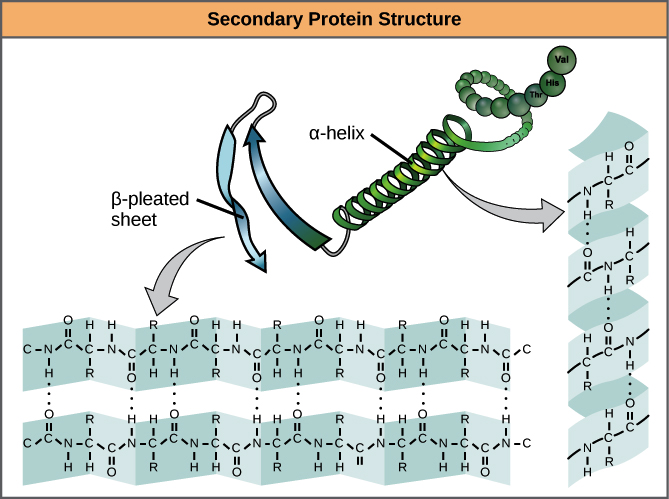

# Part I: Pretraining / Training

In [1]:
import os
import sys
os.chdir('../apps/pretrained_protein/tape')
sys.path.append('../../../')
sys.path.append('./')

## Loading related tools

In [2]:
import paddle
from utils import *

paddle.enable_static() # when paddle version >= 2.0.0rc

is_distributed = False
use_cuda = False
thread_num = 8 # for training with cpu

# Setup the execution-related parameters according to the training modes.
exe_params = default_exe_params(is_distributed=is_distributed, use_cuda=use_cuda, thread_num=thread_num)
exe = exe_params['exe']
trainer_num = exe_params['trainer_num']
trainer_id = exe_params['trainer_id']
gpu_id = exe_params['gpu_id']
dist_strategy = exe_params['dist_strategy'] 
places = exe_params['places']

## Model Configuration Settings

The network is setup according to `model_config`.
- Task-related configurations
    - "task": The type of training task. Candidate task types:
        - "pretrain": Leverage self-supervised learning for pretraining task，for dataset `TAPE`.
        - "classification": Clasification task, for dataset `Remote Homology`.
        - "regression": Regression task, for datasets `Fluroscence` and `Stability`.
        - "seq_classification": Sequence classification task, for dataset `Secondary Structure`.
    - "class_num": The number of class for tasks `classification` and `seq_classification`.
    - "label_name": The label name in the dataset.
- Network-related configurations
    - "model_type": The network type. For each network, we need to set the corresponding network hyper-parameters. We support the following networks:
        - "transformer"
            - ”hidden_size"
            - "layer_num"
            - "head_num"
        - "lstm"
            - "hidden_size"
            - "layer_num"
        - "resnet"
            - "hidden_size"
            - "layer_num"
            - "filter_size"
- Other configurations (See the code for more details)
    - "dropout_rate"
    - "weight_decay"
    
Following is the demo `model_config` of the task of `secondary_structure`.

In [3]:
model_config = \
{
    "model_name": "secondary_structure",

    "task": "seq_classification",
    "class_num": 3,
    "label_name": "labels3",

    "model_type": "lstm",
    "hidden_size": 512,
    "layer_num": 3,

    "comment": "The following hyper-parameters are optional.",
    "dropout_rate": 0.1,
    "weight_decay": 0.01
}

## Define the model

Basically we build the static graph with Paddle `Program` and `Executor`.

In [4]:
from tape_model import TAPEModel # More details of the network structure are shown in tape_model.py.
from data_gen import setup_data_loader
from pahelix.utils.paddle_utils import load_partial_params

model = TAPEModel(model_config=model_config)

lr = 0.0001 # learning rate
batch_size = 32 # batch size
train_data = './demos/secondary_structure_toy_data'

# prepare train_program
train_program = fluid.Program()
train_startup = fluid.Program()
with fluid.program_guard(train_program, train_startup):
    with fluid.unique_name.guard():
        model.forward(False)
        model.cal_loss()

        # setup the optimizer
        optimizer = default_optimizer(lr=lr, warmup_steps=0, max_grad_norm=0.1)
        setup_optimizer(optimizer, model, use_cuda, is_distributed)
        optimizer.minimize(model.loss)
        
        # setup the data loader, which provides the training data
        train_data_loader = setup_data_loader(
                model.input_list,
                model_config,
                train_data,
                trainer_id,
                trainer_num,
                places,
                batch_size)
        exe.run(train_startup)

# init_model = "./pretrained_model" # we could load the pre-trained model
# load_partial_params(exe, init_model, test_program) # load the init_model

save_program = train_program
if not is_distributed:
    save_program = train_program
    train_program = fluid.compiler.CompiledProgram(train_program).with_data_parallel(loss_name=model.loss.name)


## Train the model

In [5]:
task = model_config['task']
train_metric = get_metric(task) # evaluation metric
train_fetch_list = model.get_fetch_list() # information needed for prediction and evaluation
model_dir = "./model" # the directory to save the model

for epoch_id in range(2):
    print('Epoch %d' % epoch_id)
    train_metric.clear() # cleanup the evaluation metric
    for data in train_data_loader():
        results = exe.run(
                program=train_program,
                feed=data,
                fetch_list=train_fetch_list,
                return_numpy=False)
        update_metric(task, train_metric, results) # update the evaluation metric
        train_metric.show() # show the results of the metrics
    if trainer_id == 0:
        fluid.io.save_params(exe, '%s/epoch%d' % (model_dir, epoch_id), save_program) # save model


Epoch 0
	Example: 78011
	Accuracy: 0.324108
	Example: 144800
	Accuracy: 0.387528
Epoch 1
	Example: 78011
	Accuracy: 0.459704
	Example: 144800
	Accuracy: 0.457307


# Part II: Inference

In this part, we will briefly introduce how to use the trained model to do inference on the given amino acid sequences.

In [6]:
from pahelix.utils.paddle_utils import load_partial_params
from pahelix.utils.protein_tools import ProteinTokenizer
from data_gen import gen_batch_data

test_data = './demos/secondary_structure_toy_data'

# prepare test_program
test_program = fluid.Program()
test_startup = fluid.Program()
with fluid.program_guard(test_program, test_startup):
    with fluid.unique_name.guard():
        model.forward(True)
        test_data_loader = setup_data_loader(
                model.input_list,
                model_config,
                test_data,
                trainer_id,
                trainer_num,
                places,
                batch_size)
        exe.run(test_startup)
test_metric = get_metric(task)

init_model = "./model/epoch0" # the path of initialized model
load_partial_params(exe, init_model, test_program) # load the init_model

tokenizer = ProteinTokenizer() 
test_fetch_list = model.get_fetch_list(is_inference=True)

if use_cuda:
    place = fluid.CUDAPlace(gpu_id)
else:
    place = fluid.CPUPlace()

examples = [
    'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR',
    'CCCACAGACTCAGAGAGAACCCACCATGGTGCTGTCTCCTGACGACAAGACCAACGTCAAGGCCGCCTGGGGTAAGGTCGGCGCGCACGCTGGCGAGTATGGTGCGGAGGCCCTGGAGAGGATGTTCCTGTCCTTCCCCACCACCAAGACCTACTTCCCGCACTTCGACCTGAGCCACGGCTCTGCCCAGGTTAAGGGCCACGGCAAGAAGGTGGCCGACGCGCTGACCAACGCCGTGGCGCACGTGGACGACATGCCCAACGCGCTGTCCGCCCTGAGCGACCTGCACGCGCACAAGCTTCGGGTGGACCCGGTCAACTTCAAGCTCCTAAGCCACTGCCTGCTGGTGACCCTGGCCGCCCACCTCCCCGCCGAGTTCACCCCTGCGGTGCACGCCTCCCTGGACAAGTTCCTGGCTTCTGTGAGCACCGTGCTGACCTCCAAATACCGTTAAGCTGGAGCCTCGGTGGCCATGCTTCTTGCCCCTTTGG',
]
inputs = gen_batch_data(examples, tokenizer, place) # data process: 1.change amino acid sequence to token ids and generate a batch
results = exe.run(
    program=test_program,
    feed=inputs,
    fetch_list=test_fetch_list,
    return_numpy=False)
pred = np.array(results[0])
print(pred)

Load parameters from ./model/epoch0.
[[0.3337409  0.3321114  0.3341478 ]
 [0.3341086  0.33156016 0.3343312 ]
 [0.33405548 0.3311123  0.3348322 ]
 ...
 [0.33286792 0.3316798  0.33545232]
 [0.33306706 0.3318077  0.33512524]
 [0.3333515  0.33239156 0.33425692]]
